### Here we will visualize the outputs to a Migdal skim

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from migYOLO.utils.readYAML import read_config_file
from migYOLO.pipeline.pipeline import downsample

In [2]:
'''Open up globalConf'''
conf = read_config_file('globalConf.yaml')

In [3]:
conf

{'yoloConf': {'model': '../models/base.pt',
  'calibration_file': '../data/calibration_files/test_calibration.npy',
  'vignetting_map': '../data/calibration_files/test_map.pkl',
  'downsample_path': '../data/downsampled_images',
  'outpath': 'output',
  'save_pixels': False,
  'remove_downsample': True,
  'png_threshold': 1.4,
  'png_saturation': 4,
  'migdal_cut': 'NR_energy > 60 & centroid_dist < 6'},
 'downsample': {'dark_file': '../data/dark/sample_master_dark.npy',
  'data_dir': '../data/raw_images',
  'outpath': '../data/downsampled_images'}}

In [4]:
'''Load outputs'''
model = os.path.splitext(os.path.split(conf['yoloConf']['model'])[1])[0] #will be 'base' or 'augment'
yolodir = conf['yoloConf']['outpath']+'/%s/without_pixel_hits/'%(model)
migdal_candidate_dir = yolodir + 'migdal_candidates/'

In [5]:
os.listdir(yolodir)

['Images_batch_2.feather',
 'migdal_candidates',
 'Images_batch_1.feather',
 'Images_batch_4.feather',
 'Images_batch_5.feather',
 'Images_batch_3.feather']

In [6]:
'''Convenience functions for loading all YOLO output data. 
We add an "fnum" key to specify the file number so we can
link original frames with 'fnum' and 'original_index'''

import re
'''Convention is a number comes after an underscore in our filenames so we'll extract this'''
def find_number_in_filename(filename):
    match = re.search(r'_(\d+)', filename)
    if match:
        return match.group(1)
    return None

def load_data(migdal_candidates):
    if not migdal_candidates:
        path = yolodir
    else:
        path = migdal_candidate_dir
    dfs = []
    for fi in sorted(os.listdir(path)):
        if '.feather' in fi:
            df = pd.read_feather(path+fi)
            df['fnum'] = find_number_in_filename(fi)
            dfs.append(df)
    df = pd.concat(dfs)
    df.index = [i for i in range(0,len(df))]
    return df

In [7]:
'''Load all tracks'''

df = load_data(migdal_candidates = False)

In [8]:
'''Load Migdal candidates'''

migs = load_data(migdal_candidates = True)

### Lets plot some images

In [9]:
'''raw image directoru'''
imagepath = conf['downsample']['data_dir']

In [10]:
migs.columns

Index(['original_index', 'prediction', 'prob', 'colmin', 'colmax', 'rowmin',
       'rowmax', 'energy', 'true_length', 'centroidx', 'centroidy', 'IoU',
       'centroid_dist', 'coinc_flag', 'NR_idx', 'ER_idx', 'ER_length',
       'NR_length', 'ER_energy', 'NR_energy', 'Ediff', 'fnum'],
      dtype='object')

In [11]:
#Open up a single frame from an MTIFF
import tifffile
def quick_read(MTIFF_file,frame_index): 
    with tifffile.TiffFile(MTIFF_file) as tif: 
        image = tif.asarray(key=frame_index)
    return image

In [14]:
def plot_event(df,i,process_image):
    tmp = df.iloc[i]
    imfile_basename = 'Images_batch_'
    imname = imagepath+'/'+imfile_basename+str(tmp['fnum'])+'.MTIFF'
    im = quick_read(imname,tmp['original_index'])
    if process_image:
        a = downsample(im)
        im = a.processedImages
        im[im<0] = 0
        plt.imshow(np.log10(im+1),cmap='jet',vmin = 1.4,vmax=4)
    else:
        for col in ['colmin','colmax','rowmin','rowmax']:
            tmp[col] = tmp[col]*4
        plt.imshow(im,cmap='jet')
    colors = {0:'pink',1:'cyan',2:'red',3:'yellow',4:'goldenrod',5:'white',6:'green',7:'darkgreen',8:'white'}
    #for cmin,cmax,rmin,rmax,pred in zip(tmp['colmin'],tmp['colmax'],tmp['rowmin'],tmp['rowmax'],tmp['prediction']):
    #    plt.hlines(rmin,cmin,cmax,color = colors[pred],lw=2)
    #    plt.hlines(rmax,cmin,cmax,color = colors[pred],lw=2)
    #    plt.vlines(cmin,rmin,rmax,color = colors[pred],lw=2)
    #    plt.vlines(cmax,rmin,rmax,color = colors[pred],lw=2)
    xmin = tmp['colmin'].min()
    xmax = tmp['colmax'].max()
    ymin = tmp['rowmin'].min()
    ymax = tmp['rowmax'].max()
    plt.xlim(xmin-5,xmax+5)
    plt.ylim(ymin-5,ymax+5)

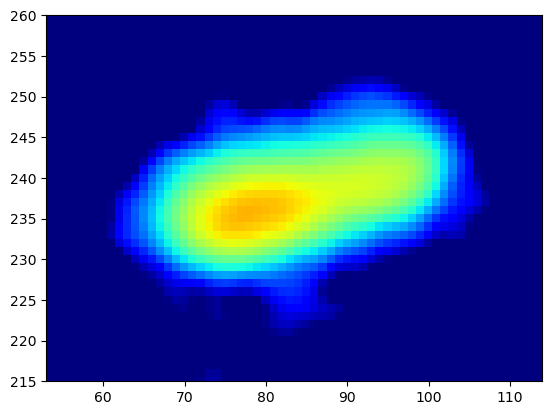

In [15]:
plot_event(migs,7,process_image = True)

In [ ]:
'''Function plots a line fit between the centroids of the bounding boxes'''

def plot_distance(df,i,process_image,BB=False):
    tmp = df.iloc[i]
    imfile_basename = 'Images_batch_'
    imname = imagepath+'/'+imfile_basename+str(tmp['fnum'])+'.MTIFF'
    im = quick_read(imname,tmp['original_index'])
    if process_image:
        a = downsample(im)
        im = a.processedImages
        im[im<0] = 0
        plt.imshow(np.log10(im+1),cmap='jet',vmin = 1.4,vmax=4)
    else:
        for col in ['colmin','colmax','rowmin','rowmax','centroidx','centroidy']:
            tmp[col] = tmp[col]*4
        plt.imshow(im,cmap='jet')
    colors = {0:'pink',1:'cyan',2:'red',3:'yellow',4:'goldenrod',5:'white',6:'green',7:'darkgreen',8:'white'}

    '''Perform line fit'''
    x1 = tmp['centroidx'][0]
    x2 = tmp['centroidx'][1]
    y1 = tmp['centroidy'][0]
    y2 = tmp['centroidy'][1]
    fit = np.polyfit([x1,x2],[y1,y2],1)
    
    '''Plot line'''
    xs = np.linspace(x1,x2,101)
    plt.plot(xs,fit[0]*xs+fit[1],color='w',lw=2)
    
    '''Optional: Plot bounding boxes'''
    if BB:
        for cmin,cmax,rmin,rmax,pred in zip(tmp['colmin'],tmp['colmax'],tmp['rowmin'],tmp['rowmax'],tmp['prediction']):
            plt.hlines(rmin,cmin,cmax,color = colors[pred],lw=2)
            plt.hlines(rmax,cmin,cmax,color = colors[pred],lw=2)
            plt.vlines(cmin,rmin,rmax,color = colors[pred],lw=2)
            plt.vlines(cmax,rmin,rmax,color = colors[pred],lw=2)
            
    
    xmin = tmp['colmin'].min()
    xmax = tmp['colmax'].max()
    ymin = tmp['rowmin'].min()
    ymax = tmp['rowmax'].max()
    plt.xlim(xmin-5,xmax+5)
    plt.ylim(ymin-5,ymax+5)

In [ ]:
plot_distance(migs,7,process_image = True, BB=True)